In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv
from scipy.stats import norm, binom, ks_2samp
from scipy import stats, linalg
import random
from decimal import Decimal
import pydtmc
from collections import Counter
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from tqdm.auto import tqdm

c:\Users\joshu\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:04<00:00, 16.08it/s]


<Figure size 1000x1000 with 0 Axes>

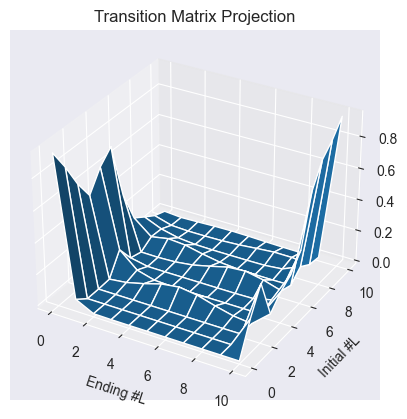

100%|██████████| 66/66 [00:04<00:00, 16.34it/s]


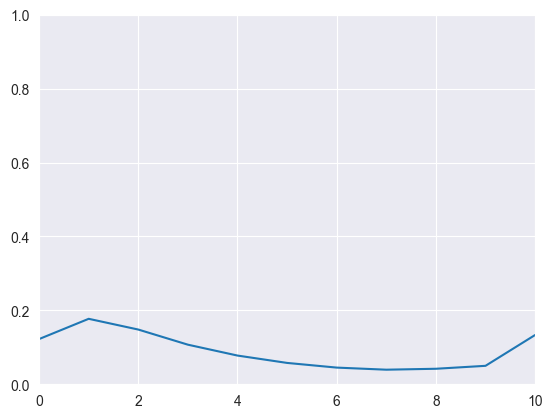

<Figure size 1000x1000 with 0 Axes>

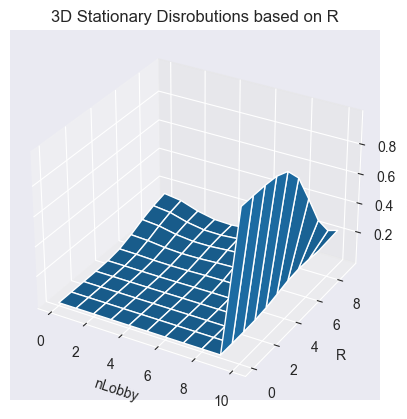

In [2]:
from ipynb.fs.full.BoringTM import *

In [3]:
## Base parameters
"""
LC = 1 ## Lobby Cost
T = 10 ## Tax
mF = 10 ## Mean Fee of Getting Caught
nPPL = 11
fR = .25
R = nPPL * fR # enforcement resources

LobH = [2] ## Lobby History, arbitrary preset
CatH = [1] ## Catch history, arbitrary preset
"""

'\nLC = 1 ## Lobby Cost\nT = 10 ## Tax\nmF = 10 ## Mean Fee of Getting Caught\nnPPL = 11\nfR = .25\nR = nPPL * fR # enforcement resources\n\nLobH = [2] ## Lobby History, arbitrary preset\nCatH = [1] ## Catch history, arbitrary preset\n'

In [4]:
def pSS1(LobH, CatH, nPPL, fR): #Gets probability of lobbying successfully, subjective
    t = len(LobH) - 1
    pss = 1 - ((.8+CatH[t]) / (1+LobH[t]))
    #print(pss)
    return pss

In [5]:
def pCat(LobH, nPPL, fR):  #Gets objective probability of success 
    R = nPPL * fR
    t = len(LobH) - 1
    if LobH[t] <= R:
  #      print(.8)
        return .8
    else:
 #       print(.8 * (R / LobH[t]))
        return .8 * (R / LobH[t])

In [6]:
def it(LobH, CatH, LC, T, mF, nPPL, fR):
    t = len(LobH)
    ps = pSS1(nPPL = nPPL, fR = fR, LobH = LobH, CatH = CatH)
    LobH.append(0)
    CatH.append(0)
    for i in range(0,nPPL+1):
        if -T < (ps * -LC) + ((1-ps) * (-T - LC - (np.random.normal(loc = mF, scale = 1)))):
            LobH[t] = LobH[t] + 1
            
    for i in range(0,LobH[t]):
        if random.random() < pCat(nPPL = nPPL, fR = fR, LobH = LobH):
            CatH[t] = CatH[t] + 1

In [7]:
def run(itr, LobH, CatH, LC, T, mF, nPPL, fR):
    for i in tqdm(range(0,itr)):
        it(LobH = LobH, CatH = CatH, LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR)

In [8]:
def set(LC, T, mF, nPPL, fR, itr):
    LobH = [randint(0,nPPL)] ## Lobby History, arbitrary preset
    CatH = [randint(0,LobH[0])] ## Catch history, arbitrary preset
    run(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr, LobH = LobH, CatH = CatH)
    return LobH, CatH

In [9]:
LobH, CatH = set(LC = 1, T = 5, mF = .5, nPPL = 10, fR = .5, itr = 1000)


100%|██████████| 1000/1000 [00:00<00:00, 22728.80it/s]


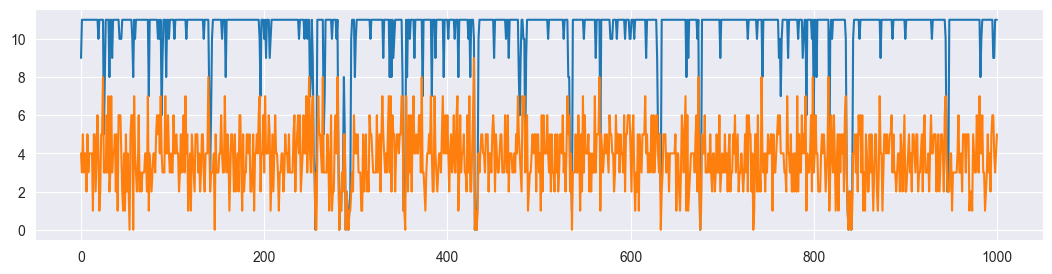

In [10]:
plt.figure(figsize=(13, 3)) 
plt.plot(LobH)
plt.plot(CatH)


In [11]:
#plt.hist(LobH, range = [0,nPPL+1])

In [12]:
def DynPDF(LC, T, mF, nPPL, fR, itr):
    MAXitr = itr
    itr = 10
    LobH, CatH = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    count, bins_count = np.histogram(LobH, bins=nPPL+1)
    pdf2 = count / sum(count) 
    pdf = [1]

    while sum(abs(pdf - pdf2)) > .01 and itr <= MAXitr:
        itr = itr * 10
        pdf = pdf2
        LobH, CatH = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
        count, bins_count = np.histogram(LobH, bins=nPPL+1)
        pdf2 = count / sum(count)
        #if itr >= MAXitr: break
    #cdf = np.cumsum(pdf) 
    #nL = range(0,nPPL+1) # equals to list(set(words))
    #Lfreq = [x/(len(LobH)) for x in list(Counter(LobH).values())] # counts the elements' frequency
    pdf = pdf2   
    return pdf, bins_count

In [13]:
DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 10, itr = 100000)[0]

100%|██████████| 1000000/1000000 [00:15<00:00, 63586.42it/s]


array([4.85779514e-01, 3.27199673e-02, 2.95799704e-03, 1.38599861e-03,
       7.00999299e-04, 3.90999609e-04, 2.66999733e-04, 2.65999734e-04,
       6.72999327e-04, 2.62399738e-03, 4.72234528e-01])

In [14]:
DPDF = DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 30, itr = 1000)[0]
pBin = 0
for i in range(0,5+1):
    pBin = pBin + DPDF[i]
pBin


100%|██████████| 10000/10000 [00:00<00:00, 20359.88it/s]


0.007499250074992501

In [35]:
def ConvTEST(LC, T, mF, nPPL, fR, itr):
       DPDF = DynPDF(fR = fR, LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr)[0]
       TMPDF = CollapsedSD(fR = fR, LC = LC, T = T, mF = mF, nPPL = nPPL)
       print(DPDF)
       print(TMPDF)
       diff = sum(abs(DPDF - TMPDF))
       print(f"Differnece is : {diff}")
       if diff < .01: print("Yay")
       else: print("sucks to suck")

In [39]:
ConvTEST(fR = .2, LC = 1, T = 5, mF = .5, nPPL = 10, itr = 1000000)

100%|██████████| 66/66 [00:04<00:00, 16.21it/s]

[9.99900010e-05 9.99900010e-05 0.00000000e+00 9.99900010e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.99980002e-04
 9.99900010e-05 1.99980002e-04 9.99200080e-01]
[8.97130336e-06 1.52101018e-05 1.82563907e-05 2.62340155e-05
 4.37700436e-05 7.60822169e-05 1.49687887e-04 3.21255240e-04
 6.87383340e-04 2.39172822e-03 9.96261421e-01]
Differnece is : 0.006376426668508139
Yay


In [16]:
TMPDF = [.1,.2,.3,.2,.1,.1]
TMPDF2 = [.3,.2,.2,.1,.1,.1]
cdf = np.cumsum(TMPDF)
cdf
#stats.kstest(TMPDF, TMPDF2)
ks_2samp(TMPDF, TMPDF2)

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.1, statistic_sign=1)

In [17]:
def GraphDynPDF(LC, T, mF, nPPL, fR, itr):
    pdf, bins_count = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.ylim([0, 1])
    plt.legend()

100%|██████████| 100000/100000 [00:01<00:00, 60016.07it/s]


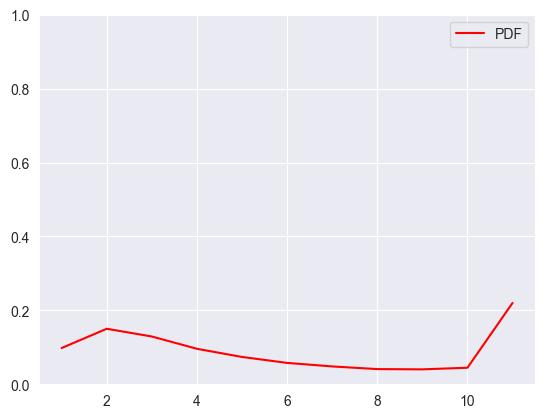

In [31]:
GraphDynPDF(fR = .8, LC = 1, T = 5, mF = .5, nPPL = 10, itr = 10000)

In [19]:
def DynItrR(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    RDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
    for i in range(2,int(1/bl+1)):
        fR = i * bl
        tRDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
        RDis = np.vstack([RDis, tRDis])
    return RDis

In [20]:
def GraphDynROut(LC, T, mF, nPPL, bl, itr):
    
    tnPPL = nPPL
    tLC = LC
    tT = T
    tmF = mF
    tbl = bl
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(0,nPPL+1)
    y = range(0,int(1/bl))

    data = DynItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr, bl = bl)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('nLobby')
    ha.set_ylabel('R')
    ha.set_zlabel('Probability')
    ha.set_title("3D Dynamic Disrobutions based on R")

    plt.show()

In [21]:
#GraphDynROut(LC = 1, T = 5, mF = .5, nPPL = 10, bl = .1, itr = 10000)